In [ ]:
import json
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import userdata
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [ ]:
# Авторизация в KAGGLE и загрузка датасета

kaggle_username = userdata.get('KAGGLE_USER')
kaggle_key = userdata.get('KAGGLE_KEY')
kaggle_token = {'username': kaggle_username, 'key': kaggle_key}

# Конфигурационный файл и права доступа

!mkdir -p ~/.kaggle
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(kaggle_token, file)
!chmod 600 ~/.kaggle/kaggle.json

# Скачивание и разархивирование

!kaggle datasets download -d vijayuv/onlineretail
!unzip -o onlineretail.zip

Dataset URL: https://www.kaggle.com/datasets/vijayuv/onlineretail
License(s): CC0-1.0
onlineretail.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  onlineretail.zip
  inflating: OnlineRetail.csv        


In [ ]:
# Кодировка указана для корректного чтения символов

df = pd.read_csv('OnlineRetail.csv', encoding='ISO-8859-1')

# ПОДГОТОВКА ДАННЫХ

In [ ]:
print('HEAD', '\n', df.head())
print('\n', 'TAIL', '\n', df.tail())

HEAD 
   InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  

 TAIL 
        InvoiceNo StockCode                      Description  Quantity  \
541904    581587     22613      PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899     CHILDREN'S APRON DOL

In [ ]:
# Приведение имен колонок к единому стилю snake_case

def to_snake_case(name):
    import re
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

df.columns = [to_snake_case(col) for col in df.columns]

print('ИМЕНА КОЛОНОК ПОСЛЕ ЗАМЕНЫ', '\n')
[print(col) for col in df.columns]

ИМЕНА КОЛОНОК ПОСЛЕ ЗАМЕНЫ 

invoice_no
stock_code
description
quantity
invoice_date
unit_price
customer_id
country


[None, None, None, None, None, None, None, None]

In [ ]:
# Оценка объема данных до чистки

print('ОБЪЕМ ДАННЫХ ДО ЧИСТКИ', '\n', df.shape)

ОБЪЕМ ДАННЫХ ДО ЧИСТКИ 
 (541909, 8)


In [ ]:
# Подсчет пропущенных значений в колонках

print('КОЛИЧЕСТВО ПРОПУСКОВ', '\n')

df.isna().sum()

КОЛИЧЕСТВО ПРОПУСКОВ 



,0
invoice_no,0
stock_code,0
description,1454
quantity,0
invoice_date,0
unit_price,0
customer_id,135080
country,0


In [ ]:
# Удаление записей с пропущенными ID клиентов

df = df.dropna(subset=['customer_id'])

# Контрольная проверка пропусков

print('КОЛИЧЕСТВО ПРОПУСКОВ ПОСЛЕ УДАЛЕНИЯ', '\n')

df.isna().sum()

КОЛИЧЕСТВО ПРОПУСКОВ ПОСЛЕ УДАЛЕНИЯ 



,0
invoice_no,0
stock_code,0
description,0
quantity,0
invoice_date,0
unit_price,0
customer_id,0
country,0


In [ ]:
# Удаление дублей и проверка итогового объема данных

df = df.drop_duplicates()

print('ОБЪЕМ ДАННЫХ ПОСЛЕ ЧИСТКИ', '\n', df.shape)

ОБЪЕМ ДАННЫХ ПОСЛЕ ЧИСТКИ 
 (401604, 8)


In [ ]:
# Просмотр типов данных для выявления требующих преобразования

print('ТИПЫ ДАННЫХ ДО ПРЕОБРАЗОВАНИЯ', '\n', df.dtypes)

ТИПЫ ДАННЫХ ДО ПРЕОБРАЗОВАНИЯ 
 invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object


In [ ]:
# Приведение типов данных к нужным форматам

# 1. Преобразование даты и обнуление(нормализация) времени

df['invoice_date'] = pd.to_datetime(df['invoice_date'])
df['invoice_date'] = df['invoice_date'].dt.normalize()

# 2. Приведение ID клиента к числу

df['customer_id'] = df['customer_id'].astype('int32')

# Контрольная проверка типов

print('ТИПЫ ДАННЫХ ПОСЛЕ ПРЕОБРАЗОВАНИЯ', '\n', df.dtypes)
print('\n', 'ДАТА ПОСЛЕ НОРМАЛИЗАЦИИ', '\n', df['invoice_date'][0])

ТИПЫ ДАННЫХ ПОСЛЕ ПРЕОБРАЗОВАНИЯ 
 invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int32
country                 object
dtype: object

 ДАТА ПОСЛЕ НОРМАЛИЗАЦИИ 
 2010-12-01 00:00:00


In [ ]:
# Удаление записей с отрицательными или нулевыми количеством или ценой (возвраты/ошибки)

df = df[(df['quantity'] > 0) & (df['unit_price'] > 0)]

# Проверка корректности удаления

negative_count = len(df[(df['quantity'] <= 0) | (df['unit_price'] <= 0)])

print('АНОМАЛЬНЫХ ЗНАЧЕНИЙ:', negative_count)

АНОМАЛЬНЫХ ЗНАЧЕНИЙ: 0


# АНАЛИЗ

In [ ]:
# ОПРЕДЕЛЕНИЕ КРИТЕРИЕВ АКТИВНОСТИ КЛИЕНТОВ И ДАТЫ ОТСЕЧКИ

# 1. Расчет медианного интервала между покупками

# Оставляем только уникальные дни покупок

daily_orders_df = df[['customer_id', 'invoice_date']].drop_duplicates()
daily_orders_df = daily_orders_df.sort_values(by=['customer_id', 'invoice_date'])

# Расчет разницы в днях между покупками (исключая покупателей с одной покупкой)

daily_orders_df['total_orders'] = daily_orders_df.groupby('customer_id')['invoice_date'].transform('count')
daily_orders_df = daily_orders_df[daily_orders_df['total_orders'] > 1]
daily_orders_df['days_diff'] = daily_orders_df.groupby('customer_id')['invoice_date'].diff().dt.days

# Расчет медианного интервала по всем клиентам

daily_orders_df = daily_orders_df.groupby('customer_id').agg(
    median_diff=('days_diff', 'median')
)
median_days_between_orders = daily_orders_df['median_diff'].median()

print('МЕДИАННЫЙ ИНТЕРВАЛ МЕЖДУ ПОКУПКАМИ:', median_days_between_orders)

# 2. Определение временных границ датасета и выбор дельты активных клиентов

min_date = df['invoice_date'].min()
max_date = df['invoice_date'].max()
dataset_duration = (max_date - min_date).days

delta_min_limit = median_days_between_orders
delta_max_limit = dataset_duration / 2

print('\n', 'ПРОДОЛЖИТЕЛЬНОСТЬ СБОРА ИСХОДНЫХ ДАННЫХ:', dataset_duration, ' ДНЕЙ')
print('\n', 'ДИАПАЗОН ВЫБОРА ДЕЛЬТЫ:', f'{delta_min_limit} - {delta_max_limit}', 'ДНЕЙ')

# Выбор дельты активных клиентов (срок их возврата) и расчет даты отсечки

active_delta_days = 105 # интервал между покупками * 2

cutoff_date = df['invoice_date'].max() - pd.Timedelta(days=active_delta_days)

print('\n', 'ВЫБРАННАЯ ДЕЛЬТА:', active_delta_days)
print('\n', 'ДАТА ОТСЕЧКИ:', cutoff_date)

МЕДИАННЫЙ ИНТЕРВАЛ МЕЖДУ ПОКУПКАМИ: 52.5

 ПРОДОЛЖИТЕЛЬНОСТЬ СБОРА ИСХОДНЫХ ДАННЫХ: 373  ДНЕЙ

 ДИАПАЗОН ВЫБОРА ДЕЛЬТЫ: 52.5 - 186.5 ДНЕЙ

 ВЫБРАННАЯ ДЕЛЬТА: 105

 ДАТА ОТСЕЧКИ: 2011-08-26 00:00:00


In [ ]:
# Определение живых клиентов (вернувшихся после даты отсечки)

after_df = df[df['invoice_date'] > cutoff_date]
after_ids = after_df['customer_id'].unique()

print('АКТИВНЫХ КЛИЕНТОВ ПОСЛЕ ОТСЕЧКИ:', len(after_ids))

АКТИВНЫХ КЛИЕНТОВ ПОСЛЕ ОТСЕЧКИ: 2996


In [ ]:
# Подготовка признаков (RFM) для модели на данных из прошлого

# 1. Выделение обучающего периода (прошлое, до даты отсечки)

before_df = df[df['invoice_date'] <= cutoff_date].copy()

# 2. Расчет RFM

# Расчет полной суммы заказа

before_df['total_sum'] = before_df['unit_price'] * before_df['quantity']

# Агрегация по каждому клиенту

rfm_before_df = before_df.groupby('customer_id').agg(
    Recency=('invoice_date', lambda x: (cutoff_date - x.max()).days),
    Frequency=('invoice_no', 'nunique'),
    Monetary=('total_sum', 'sum')
)

print('RFM ДЛЯ ОБУЧЕНИЯ МОДЕЛИ', '\n', rfm_before_df.head())

RFM ДЛЯ ОБУЧЕНИЯ МОДЕЛИ 
              Recency  Frequency  Monetary
customer_id                              
12346            220          1  77183.60
12347             24          5   2790.86
12348            143          3   1487.24
12350            205          1    334.40
12352            157          5   1561.81


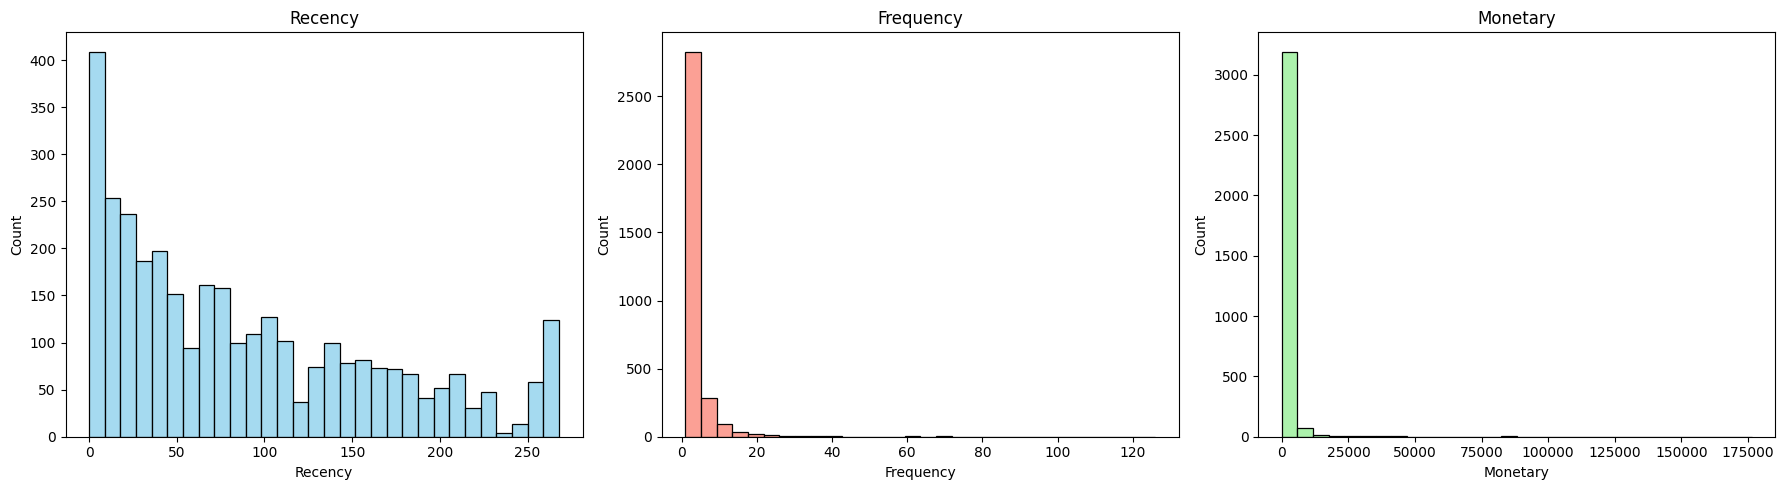

In [ ]:
# Визуализация распределения RFM (проверка на выбросы и аномалии)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(rfm_before_df['Recency'], bins=30, ax=axes[0], color='skyblue')
sns.histplot(rfm_before_df['Frequency'], bins=30, ax=axes[1], color='salmon')
sns.histplot(rfm_before_df['Monetary'], bins=30, ax=axes[2], color='lightgreen')

axes[0].set_title('Recency')
axes[1].set_title('Frequency')
axes[2].set_title('Monetary')

plt.tight_layout()
plt.show()

In [ ]:
# Ограничение выбросов по 99-му процентилю

f_threshold = rfm_before_df['Frequency'].quantile(0.99)
m_threshold = rfm_before_df['Monetary'].quantile(0.99)

rfm_before_df['Frequency'] = rfm_before_df['Frequency'].clip(upper=f_threshold)
rfm_before_df['Monetary'] = rfm_before_df['Monetary'].clip(upper=m_threshold)

print('ВЕРХНЯЯ ГРАНИЦА FREQUENCY:', f_threshold)
print('ВЕРХНЯЯ ГРАНИЦА MONETARY:', m_threshold)

ВЕРХНЯЯ ГРАНИЦА FREQUENCY: 22.0
ВЕРХНЯЯ ГРАНИЦА MONETARY: 14362.910800000007


In [ ]:
# Формирование целевой переменной. 1 - клиент не вернулся после даты отсечки, 0 - вернулся

rfm_before_df['is_churn'] = (~rfm_before_df.index.isin(after_ids)).astype('int32')

# Проверка баланса активных и ушедших

churn_balance = rfm_before_df['is_churn'].value_counts(normalize=True)

print('\n', 'БАЛАНС ОТТОКА', '\n', churn_balance)
print('\n', 'ТАБЛИЦА ДЛЯ ОБУЧЕНИЯ МОДЕЛИ', '\n', rfm_before_df.head())


 БАЛАНС ОТТОКА 
 is_churn
0    0.593949
1    0.406051
Name: proportion, dtype: float64

 ТАБЛИЦА ДЛЯ ОБУЧЕНИЯ МОДЕЛИ 
              Recency  Frequency    Monetary  is_churn
customer_id                                          
12346            220          1  14362.9108         1
12347             24          5   2790.8600         0
12348            143          3   1487.2400         0
12350            205          1    334.4000         1
12352            157          5   1561.8100         0


In [ ]:
# Разделение данных на признаки и ответы для модели

x = rfm_before_df[['Recency', 'Frequency', 'Monetary']]
y = rfm_before_df['is_churn']

# Проверка корректности выборки

print('ПРИЗНАКИ ДЛЯ МОДЕЛИ', '\n', x.head())
print('\n', 'ОТВЕТЫ ДЛЯ МОДЕЛИ', '\n', y.head())

ПРИЗНАКИ ДЛЯ МОДЕЛИ 
              Recency  Frequency    Monetary
customer_id                                
12346            220          1  14362.9108
12347             24          5   2790.8600
12348            143          3   1487.2400
12350            205          1    334.4000
12352            157          5   1561.8100

 ОТВЕТЫ ДЛЯ МОДЕЛИ 
 customer_id
12346    1
12347    0
12348    0
12350    1
12352    0
Name: is_churn, dtype: int32


In [ ]:
# Обучение модели на данных из прошлого

# 1. Разделение данных на обучающие и тестовые (80/20)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=25)

print('КОЛ-ВО ЗАПИСЕЙ ОБУЧЕНИЕ/ТЕСТ:', f'{x_train.shape[0]}/{x_test.shape[0]}')

# 2. Инициализация и обучение модели

model = RandomForestClassifier(n_estimators=200, random_state=25)
model.fit(x_train, y_train)

# 3. Тестирование и проверка точности

predictions = model.predict(x_test)
model_accuracy = accuracy_score(y_test, predictions)

print('\n', 'ТОЧНОСТЬ МОДЕЛИ:', model_accuracy)

КОЛ-ВО ЗАПИСЕЙ ОБУЧЕНИЕ/ТЕСТ: 2644/661

 ТОЧНОСТЬ МОДЕЛИ: 0.6338880484114977


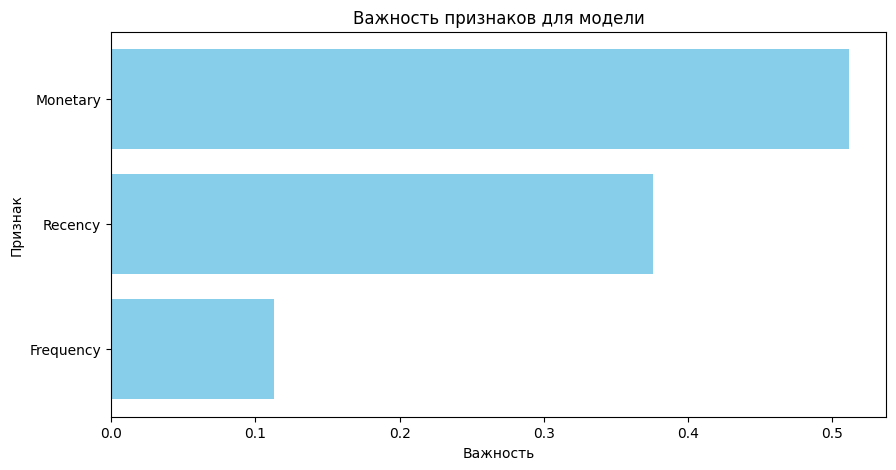

In [ ]:
# Визуализация важности признаков для модели

# 1. Анализ важности

importances = model.feature_importances_
feature_names = x.columns

# 2. Подготовка таблицы для визуализации

feature_importances_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)

# 3. Построение графика

plt.figure(figsize=(10, 5))
plt.barh(feature_importances_df['feature'], feature_importances_df['importance'], color='skyblue')

plt.xlabel('Важность')
plt.ylabel('Признак')
plt.title('Важность признаков для модели')

plt.gca().invert_yaxis() # сверху-вниз по убыванию важности

plt.show()

In [ ]:
# Сбор актуальных RFM по всей базе

today = df['invoice_date'].max()

df['total_sum'] = df['unit_price'] * df['quantity']

current_rfm_df = df.groupby('customer_id').agg(
    Recency=('invoice_date', lambda x: (today - x.max()).days),
    Frequency=('invoice_no', 'nunique'),
    Monetary=('total_sum', 'sum')
)

print('ДАТА АКТУАЛЬНОГО СРЕЗА:', today)
print('\n', 'RFM ВСЕХ КЛИЕНТОВ:', '\n', current_rfm_df.head())

ДАТА АКТУАЛЬНОГО СРЕЗА: 2011-12-09 00:00:00

 RFM ВСЕХ КЛИЕНТОВ: 
              Recency  Frequency  Monetary
customer_id                              
12346            325          1  77183.60
12347              2          7   4310.00
12348             75          4   1797.24
12349             18          1   1757.55
12350            310          1    334.40


In [ ]:
# Применение модели к актуальным данным

# 1. Приведение выбросов к тем же границам, что и при обучении

current_rfm_df['Frequency'] = current_rfm_df['Frequency'].clip(upper=f_threshold)
current_rfm_df['Monetary'] = current_rfm_df['Monetary'].clip(upper=m_threshold)

# 2. Расчет вероятности оттока

x_current = current_rfm_df[['Recency', 'Frequency', 'Monetary']]
current_rfm_df['churn_prob'] = model.predict_proba(x_current)[:, 1]

# 3. Сортировка по убыванию вероятности оттока

current_rfm_df = current_rfm_df.sort_values(by='churn_prob', ascending=False)

print('КЛИЕНТЫ С НАИБОЛЬШЕЙ ВЕРОЯТНОСТЬЮ ОТТОКА', '\n', current_rfm_df['churn_prob'].head(10))

КЛИЕНТЫ С НАИБОЛЬШЕЙ ВЕРОЯТНОСТЬЮ ОТТОКА 
 customer_id
16148    1.000
14373    1.000
17752    1.000
13747    1.000
14090    1.000
17995    1.000
18113    1.000
15753    1.000
16078    1.000
15204    0.995
Name: churn_prob, dtype: float64


# РЕЗУЛЬТАТ

In [ ]:
# Формирование итогового списка (клиент-вероятность_оттока-выручка)

result_df = current_rfm_df.reset_index()[['customer_id', 'churn_prob', 'Monetary']]

# Переименование для наглядности

result_df = result_df.rename(columns={'Monetary': 'revenue'})

# Сортировка по убыванию риска и ценности (выручки)

result_df = result_df.sort_values(by=['churn_prob', 'revenue'], ascending=False)

print('ИТОГОВЫЙ СПИСОК', '\n', result_df.head(10))

ИТОГОВЫЙ СПИСОК 
     customer_id  churn_prob  revenue
2         17752       1.000    80.64
3         13747       1.000    79.60
7         15753       1.000    79.20
8         16078       1.000    79.20
1         14373       1.000    76.55
0         16148       1.000    76.32
4         14090       1.000    76.32
6         18113       1.000    76.32
5         17995       1.000    76.10
10        14489       0.995   463.38


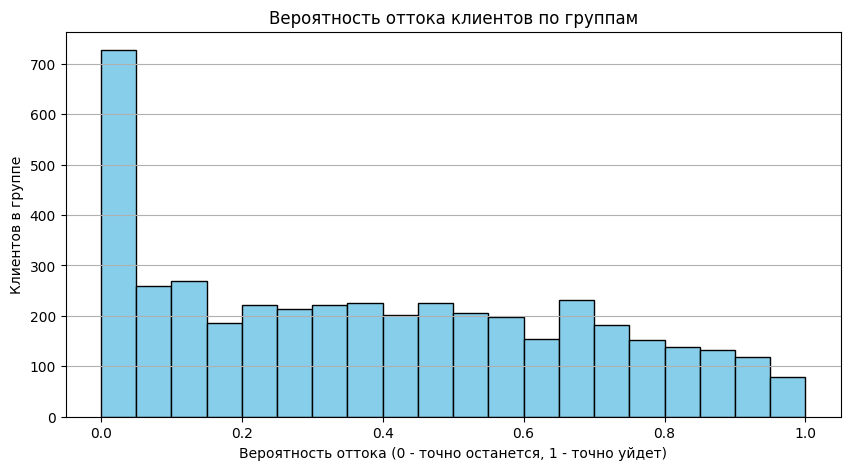

In [ ]:
### Визуализация групп по вероятности оттока

plt.figure(figsize=(10, 5))

plt.hist(result_df['churn_prob'], bins=20, color='skyblue', edgecolor='black')

plt.xlabel('Вероятность оттока (0 - точно останется, 1 - точно уйдет)')
plt.ylabel('Клиентов в группе')
plt.title('Вероятность оттока клиентов по группам')

plt.grid(axis='y')

plt.show()

**Выводы**:

1. Главный фактор оттока - выручка. Модель показала, что общая сумма покупок имеет большее значение для прогноза, чем давность и частота.

2. Уровень лояльности большинства клиентов - средне-высокий: можно не тратить бюджет на всех подряд, а работать точечно.

**Итоги**:

1. Построена модель прогнозирования оттока на основе RFM с точностью 63%.

2. Сформирован список клиентов с указанием вероятности оттока и общей выручки.

**Рекомендации**:

Сосредоточиться на клиентах с вероятностью оттока 40-60% (звонок, письмо). Работа с этой группой даст наибольшую отдачу на одно действие.